# Can Frequency Analysis of Identifiers be Used to Identify the Programmming Language of a Source Code Snippet?

#### Author: Abdullah Shuaib

## Introduction

Looking at a source code file, a seasoned programmer can easily recognize which programming language it is written in. I've noticed that on the other hand, many programming editors/tools require users to manually select which programming language is being written to offer the appropriate syntax highlighting, linting, and/or compiling tools. These experiences left me wondering, can Natural Language Processing techniques be used to programmatically identify the language of a code snippet?

Source code files are structured quite differently relative to natural language documents such as articles, essays, and reviews. As such, many tools for analyzing code files such as static code analysis tools consider the syntax of a programming language. For our use case, however, this is problematic because syntax varies widely between programming languages, and we obviously do not have knowledge of the language of a code snippet beforehand. 

On the other hand, many analyses on natural language documents have been done without consideration to syntax by simply [treating a document as a bag of words and analyzing the frequency of terms within the document](https://www.mygreatlearning.com/blog/bag-of-words/#ed6). Could we use this approach with source code documents as well? 

Different programming languages oftentimes use different keywords ("implements", "void", "import", "var"), operators ("=" vs "==" vs "===", "++" vs "+="), and separators (parentheses, brackets, whitespace). Additionally, programmers often use similar functions when programming in the same language such as pandas/numpy functions in Python, memory allocation functions in C/C++, etc. It is thus plausible that such an approach to programming language identification can work reasonably well.

## Data Curation

I originally intended to use [this Identifiers dataset](https://github.com/src-d/datasets/tree/master/Identifiers) I found on [awesome-public-datasets](https://github.com/awesomedata/awesome-public-datasets#software) which contained information about the frquency of tokens in source code by programming language. However, I found that I was unable to access the database as the maintenance team had since left the project and are no longer hosting the data.

However, I luckily came upon the [Github Activity Dataset](https://console.cloud.google.com/marketplace/product/github/github-repos) with 3TB+ of data released through the [Google BigQuery Public Datasets program](https://cloud.google.com/bigquery/public-data/). This dataset includes an enormous quantity of Git data including millions of commits, tons of source code documents, and much more. 

Setting up BigQuery and querying was pretty straightforward. However, I ran into issues exporting the resultant data into a csv file due to the large size of the data. Luckily, I found a workaround solution [here](https://www.kaggle.com/amalhasni/creating-labeled-code-snippets-dataset) using a custom BigQuery helper library for easily querying large BigQuery datasets and exporting results. However, this library only works on Kaggle's platform, so I had to perform the following steps to retrieve the dataset:

1.   Create a Kaggle account (Can use Google SSO).
2.   Fork [this notebook](https://www.kaggle.com/amalhasni/creating-labeled-code-snippets-dataset) by clicking "Copy & Edit" at the top right corner.
3.   Run all the cells (the querying step will take several minutes).
4.   Download the csv file output by the last cell.

Note: **You do not need to perform these steps** as I have uploaded the csv file to the cloud and provided a URL from which the csv can be downloaded locally and then loaded into a pandas dataframe in the code below.


In [40]:
%pip install wordcloud

import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [2]:
# Download file locally from "https://drive.google.com/file/d/1tmjheFKjdlIXnG8CZPjYPRQ2ajr2gYhT/view?usp=sharing"

# Replace with path to your local copy
path = "drive/MyDrive/data.csv"
df = pd.read_csv(path)

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,content,language
0,0,module VirtualBox\n module COM\n class Uti...,Ruby
1,1,describe Travis::API::V3::Renderer::AvatarURL ...,Ruby
2,2,module Model\n class DictionaryValue < Sequel...,Ruby
3,3,class Task::Skill < ActiveRecord::Base\n has_...,Ruby
4,4,# encoding: utf-8\n\nrequire 'ffaker/address'\...,Ruby


We now have a dataframe containing code snippets labelled by language. Let's clean up the data a little bit.

We will drop the NaN rows and the unneeded "Unnamed: 0" column. After that, we reset the index to correspond to the new set of rows.


In [3]:
df.dropna(inplace=True)
df.drop("Unnamed: 0",1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,content,language
0,module VirtualBox\n module COM\n class Uti...,Ruby
1,describe Travis::API::V3::Renderer::AvatarURL ...,Ruby
2,module Model\n class DictionaryValue < Sequel...,Ruby
3,class Task::Skill < ActiveRecord::Base\n has_...,Ruby
4,# encoding: utf-8\n\nrequire 'ffaker/address'\...,Ruby
...,...,...
131444,# promise-any\n\n[ ![Codeship Status for m0ppe...,Markdown
131445,looker_embed_sso_examples\n===================...,Markdown
131446,Php Reports\n===========\n\nA reporting framew...,Markdown
131447,# EspGrid\n\nEspGrid is a software system to s...,Markdown


We also need to cast the language and content columns to strings so that we can treat the code snippets and language labels as srings and use string utilities to work with them.

In [4]:
df.language = df.language.astype("string")
df.content = df.content.astype("string")
df.dtypes

content     string
language    string
dtype: object

Learn more about the BigQuery Github Activity Dataset:

1.   [Google Cloud Announcement](https://cloud.google.com/blog/topics/public-datasets/github-on-bigquery-analyze-all-the-open-source-code)
2.   [GitHub Announcement](https://github.blog/2016-06-29-making-open-source-data-more-available/)
3.   [Example queries (syntax is a little outdated)](https://gist.github.com/arfon/49ca314a5b0a00b1ebf91167db3ff02c#most-commonly-used-go-packages)

## Exploratory Data Analysis

Let's see which languages we have code snippets for.

In [76]:
df.language.unique()

<StringArray>
[            'Ruby',            'Swift',            'Shell',
              'Lua',            'Scala',              'PHP',
       'TypeScript',             'HTML',              'SQL',
         'Markdown',           'Python',           'Kotlin',
             'Perl',     'CoffeeScript',       'PowerShell',
            'Julia',               'C#',             'Dart',
              'CSS',               'Go',          'Haskell',
        'Batchfile',             'Rust',           'Groovy',
             'Java',      'Objective-C',       'JavaScript',
     'Visual Basic',              'TeX',              'C++',
           'Erlang', 'Jupyter Notebook',           'Pascal',
                'C']
Length: 34, dtype: string

It looks like we have code snippets for 34 different languages! 


---


Now let's look at some of the most common words in each language. 

We start by creating a CountVectorizer which converts the series of code snippets into a bag of words matrix containing words and their frequencies in each document. We want to look at some of the common keywords, operators, and delimiters in each language, so we will create 3 different vectorizers (with different tokenizing regex patterns) to grab these identifiers and analyze them separately. 

We then visualize the most common identifiers of each type using Word Clouds. For this, we first sum up the occurences of each word over all documents, then map each word to its respective count. Then, we can easily use WordCloud's `generate_from_frequencies(freq_dict)` to make the Word Clouds and plot them.

Below we look at the Word Clouds for Python, C, and Java.



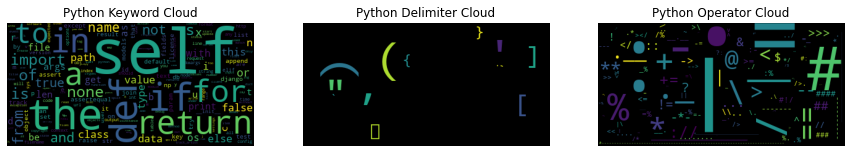

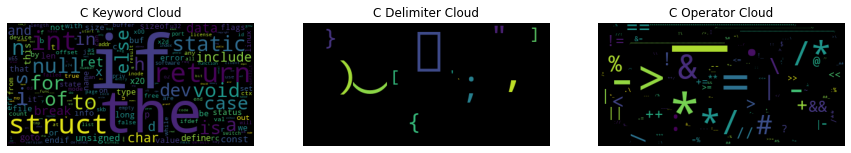

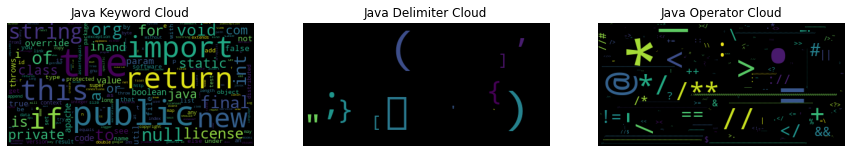

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

langs = ["Python", "C", "Java"]

for lang in langs:
  kw_pattern = r"""([A-Za-z_]\w*\b)"""
  kw_vectorizer = CountVectorizer(token_pattern = kw_pattern)

  op_pattern = r"""([!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+)"""
  op_vectorizer = CountVectorizer(token_pattern = op_pattern)

  delim_pattern = r"""([ \t\(\),;\{\}\[\]"'`])"""
  delim_vectorizer = CountVectorizer(token_pattern = delim_pattern)

  lang_code = df[df.language == lang].content
  BoWs = {"keywords": kw_vectorizer.fit_transform(lang_code),
            "operators": op_vectorizer.fit_transform(lang_code),
            "delimiters": delim_vectorizer.fit_transform(lang_code)}

  kw_counts = np.asarray(BoWs["keywords"].sum(axis=0))[0]
  kw_words = kw_vectorizer.get_feature_names_out()
  kw_word_freq = dict(zip(kw_words,kw_counts))

  op_counts = np.asarray(BoWs["operators"].sum(axis=0))[0]
  op_words = op_vectorizer.get_feature_names_out()
  op_word_freq = dict(zip(op_words,op_counts))

  delim_counts = np.asarray(BoWs["delimiters"].sum(axis=0))[0]
  delim_words = delim_vectorizer.get_feature_names_out()
  delim_word_freq = dict(zip(delim_words,delim_counts))

  fig = plt.figure(figsize = (15,15))
  k = 1

  for title, freq in [("Keyword Cloud", kw_word_freq), ("Delimiter Cloud", delim_word_freq), ("Operator Cloud",op_word_freq)]:
    ax = fig.add_subplot(len(langs),3,k)
    cloud = WordCloud()
    cloud.generate_from_frequencies(freq)
    ax.imshow(cloud)
    ax.axis("off")
    ax.set_title(lang+ " " +title)
    k += 1


We can see that Python, C, and Java have some unique keywords but also many common keywords such as "if", "import", and "the". This pattern holds for delimiters and operators as well. However, these may not be as similar as they seem since the relative frequencies of words are not comparable across languages in these clouds. Nevertheless, we can begin to get an idea of how these languages can be distinguished.

## Machine Learning

We start by splitting the data into a training set and a testing set for holdout validation using `train_test_split` provided by sklearn.

In [78]:
from sklearn.model_selection import train_test_split

X = df.content
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
     ('vect', CountVectorizer(token_pattern=r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])""")),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', random_state=42,
                           max_iter=5, tol=None)),
])

In [80]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(token_pattern='([A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\t\\(\\),;\\{\\}\\[\\]"\'`])')),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(max_iter=5, random_state=42, tol=None))])

In [81]:
acc = text_clf.score(X_test, y_test)
acc

0.907138328895651

In [82]:
from sklearn.tree import DecisionTreeClassifier

text_clf_dt = Pipeline([
     ('vect', CountVectorizer(token_pattern=r"""([A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]"'`])""")),
     ('tfidf', TfidfTransformer()),
     ('clf', DecisionTreeClassifier()),
])

In [ ]:
text_clf_dt.fit(X_train, y_train)

In [18]:
acc_dt = text_clf_dt.score(X_test, y_test)
acc_dt

0.899657664511221

## Conclusion